## Modulación ISB (Independent Side Band)

La modulación ISB permite transmitir simultáneamente dos señales diferentes, una por cada banda lateral (USB y LSB), aprovechando de manera eficiente el espectro asignado. Es útil en sistemas donde se desea enviar dos flujos de información separados, como en transmisión de audio estéreo.

---

### Señal Modulada ISB

La señal modulada ISB se expresa como:

```math
s_{ISB}(t) = m_1(t)\cos(2\pi f_c t) + \hat{m}_1(t)\sin(2\pi f_c t) + m_2(t)\cos(2\pi f_c t) + \hat{m}_2(t)\sin(2\pi f_c t)
```

* $m_1(t)$: mensaje en banda lateral superior (USB)
* $m_2(t)$: mensaje en banda lateral inferior (LSB)
* $\hat{m}_1(t), \hat{m}_2(t)$: transformadas de Hilbert de $m_1(t)$ y $m_2(t)$

---

### Separación de Bandas Laterales

Las componentes de la señal ISB pueden representarse por separado como:

```math
s_{USB}(t) = m_1(t)\cos(2\pi f_c t) + \hat{m}_1(t)\sin(2\pi f_c t)
```

```math
s_{LSB}(t) = m_2(t)\cos(2\pi f_c t) + \hat{m}_2(t)\sin(2\pi f_c t)
```

---

### Transformada de Hilbert

La transformada de Hilbert de una señal $x(t)$ genera una versión en cuadratura $\hat{x}(t)$, y permite formar una señal analítica:

```math
x_a(t) = x(t) + j\hat{x}(t)
```

En el dominio de la frecuencia, se expresa como:

```math
\mathcal{F}\{\hat{x}(t)\} = -j \cdot \text{sgn}(f) \cdot X(f)
```

---

### Efectos de Errores de Fase y Frecuencia

En demodulación sincrónica, los errores en la frecuencia o fase de la portadora local causan distorsión. Se modelan así:

```math
\cos(2\pi (f_c + \Delta f)t + \phi)
```

* $\Delta f$: error de frecuencia
* $\phi$: error de fase

---

### Demodulación ISB

Multiplicando la señal ISB por $\cos(2\pi f_c t)$, se obtiene:

```math
\begin{aligned}
s_{ISB}(t)\cos(2\pi f_c t) &= (m_1(t)\cos(2\pi f_c t) - \hat{m}_1(t)\sin(2\pi f_c t))\cos(2\pi f_c t) \\
&+ (m_2(t)\cos(2\pi f_c t) - \hat{m}_2(t)\sin(2\pi f_c t))\cos(2\pi f_c t)
\end{aligned}
```

Desarrollando:

```math
\begin{aligned}
s_{ISB}(t)\cos(2\pi f_c t) = \frac{1}{2} m_1(t) + \frac{1}{2} m_1(t)\cos(2\pi f_c t) - \hat{m}_1(t)\sin(2\pi f_c t) \\
+ \frac{1}{2} m_2(t) + \frac{1}{2} m_2(t)\cos(2\pi f_c t) - \hat{m}_2(t)\sin(2\pi f_c t)
\end{aligned}
```

Después de filtrar las componentes en alta frecuencia, se puede recuperar $m_1(t)$ y $m_2(t)$ de forma separada.

---

### Nota Final

La modulación ISB requiere un receptor con capacidad de separar eficientemente las bandas laterales mediante filtros selectivos y sincronización precisa, lo que la hace más compleja que otras modulaciones como DSB o SSB, pero también más versátil.

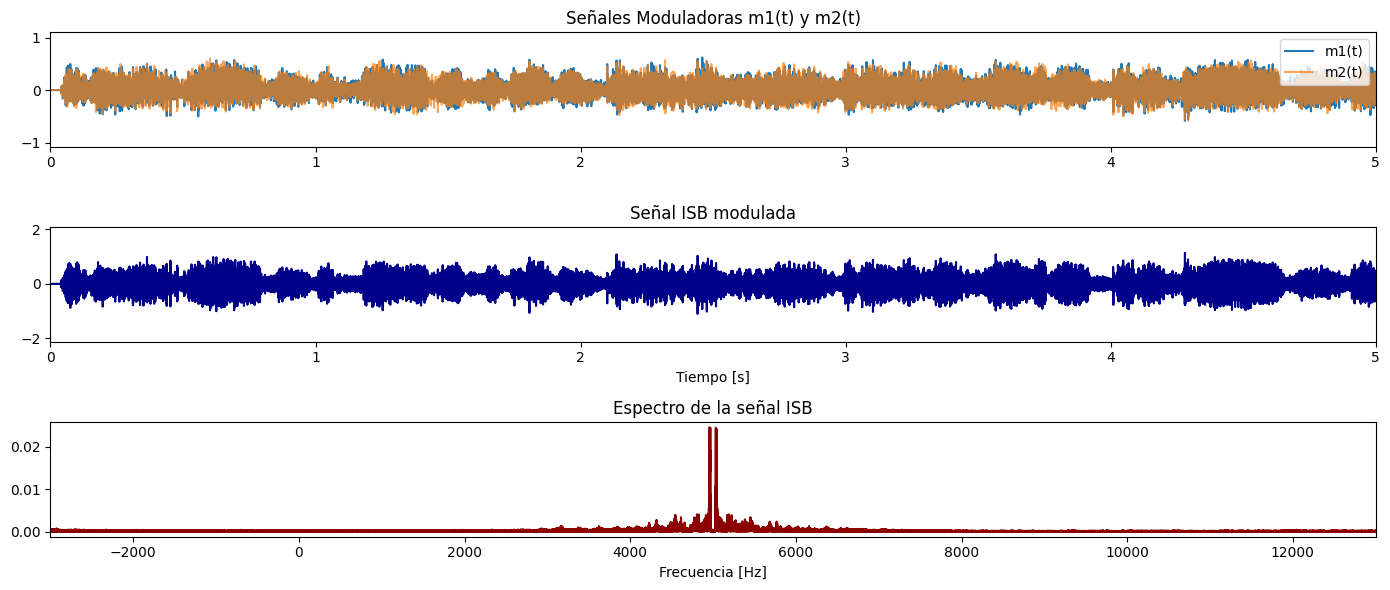

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import hilbert
from scipy.fft import fft, fftfreq, fftshift

# 1. Cargar archivo WAV estéreo
fs, tone = wav.read('../utils/music_estereo.wav')

# Asegurarse de que es estéreo
if tone.ndim < 2 or tone.shape[1] < 2:
    raise ValueError("Se requiere un archivo de audio estéreo (2 canales).")

time_limit = 5

# Separar canales
m1 = tone[:, 0].astype(np.float32)
m2 = tone[:, 1].astype(np.float32)

# Normalizar
m1 /= np.max(np.abs(m1))
m2 /= np.max(np.abs(m2))

# Asegurar misma longitud
N = min(len(m1), len(m2))
m1 = m1[:N]
m2 = m2[:N]
t = np.arange(N) / fs

# 2. Obtener transformadas de Hilbert
m1_hilbert = np.imag(hilbert(m1))  # -> hat(m1)
m2_hilbert = np.imag(hilbert(m2))  # -> hat(m2)

# 3. Generar portadoras
fc = 5000  # Hz
cos_carrier = np.cos(2 * np.pi * fc * t)
sin_carrier = np.sin(2 * np.pi * fc * t)

# 4. Modulación ISB: suma de cada banda lateral independiente
s_isb = (m1 * cos_carrier + m1_hilbert * sin_carrier) + \
        (m2 * cos_carrier - m2_hilbert * sin_carrier)

# 5. Graficar señales en el tiempo
plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.title("Señales Moduladoras m1(t) y m2(t)")
plt.plot(t, m1, label='m1(t)')
plt.plot(t, m2, label='m2(t)', alpha=0.7)
plt.legend()
plt.xlim(0, time_limit)

plt.subplot(3, 1, 2)
plt.title("Señal ISB modulada")
plt.plot(t, s_isb, color='darkblue')
plt.xlabel("Tiempo [s]")
plt.xlim(0, time_limit)

# 6. Espectro
S = fft(s_isb)
freqs = fftfreq(N, 1/fs)
S_mag = np.abs(fftshift(S)) / N

plt.subplot(3, 1, 3)
plt.title("Espectro de la señal ISB")
plt.plot(fftshift(freqs), S_mag, color='darkred')
plt.xlabel("Frecuencia [Hz]")
plt.xlim(fc - 8000, fc + 8000)
plt.tight_layout()
plt.show()


# Demodular

Reproduciendo señal ISB demodulada...


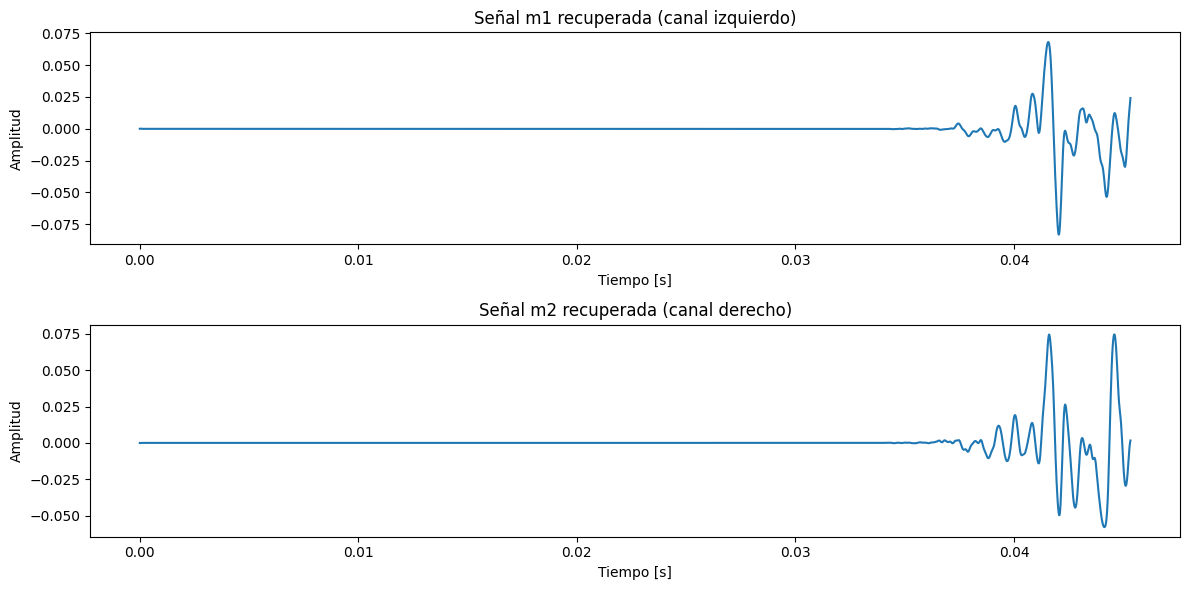

In [5]:
from scipy.signal import butter, filtfilt, hilbert
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd

# Filtro pasa bajas
def lowpass(signal, fs, cutoff=5000, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# -------------------------------
# Demodulación coherente ISB
# -------------------------------

# Señales en cuadratura
cos_carrier = np.cos(2 * np.pi * fc * t)
sin_carrier = np.sin(2 * np.pi * fc * t)

# Mezcla sincrónica
y_cos = 2 * s_isb * cos_carrier
y_sin = 2 * s_isb * sin_carrier

# Filtrar componentes en banda base
I = lowpass(y_cos, fs)
Q = lowpass(y_sin, fs)

# Recuperar señales originales
# Basado en la modulación: s = m1*cos + hat(m1)*sin + m2*cos - hat(m2)*sin
# Así que:
# I = m1 + m2
# Q = hat(m1) - hat(m2)
# Para separar m1 y m2:
I_hilbert = np.imag(hilbert(I))
Q_hilbert = np.imag(hilbert(Q))

# Recuperar m1 y m2 por combinación (aproximación)
m1_rec = 0.5 * (I + Q_hilbert)
m2_rec = 0.5 * (I - Q_hilbert)

# Normalizar
m1_rec /= np.max(np.abs(m1_rec))
m2_rec /= np.max(np.abs(m2_rec))

# Reproducir mezcla estéreo recuperada
stereo_rec = np.vstack((m1_rec, m2_rec)).T
print("Reproduciendo señal ISB demodulada...")
sd.play(m2_rec, fs)
sd.wait()

# Graficar señales recuperadas
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t[:2000], m1_rec[:2000])
plt.title("Señal m1 recuperada (canal izquierdo)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")

plt.subplot(2, 1, 2)
plt.plot(t[:2000], m2_rec[:2000])
plt.title("Señal m2 recuperada (canal derecho)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()
